In [2]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pandas_summary import DataFrameSummary
import seaborn as sns
import math


from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
pd.set_option('display.max_columns', 60)


In [2]:
def clean_data(df):
    '''
    INPUT: pandas df
    OUTPUT: cleaned df
    
    convert bool features to proper 0/1
    drop list features
    create intercept
    only keep intercept, numeric_features, bool_features
    
    TO DO: 
    1. create dummies for some catergorical features
    2. parse list/text features to extract features
    3. remove irrelevant features
    
    '''
    df['fraud'] = df['acct_type'].apply(lambda x:True if 'fraud' in x else False)
    df = df.drop('acct_type',1)
    dfs = DataFrameSummary(df.drop(['ticket_types','previous_payouts'],1))
    col_stat = dfs.columns_stats
    feat_type=col_stat.iloc[4,:].reset_index()
    numeric_features = list(feat_type[feat_type['types'] =='numeric']['index'])
    bool_features = list(feat_type[feat_type['types'] =='bool']['index'])
    categorical_features = list(feat_type[feat_type['types'] =='categorical']['index'])
    list_features = ['ticket_types','previous_payouts']
    text_features = ['description','org_desc','name','org_name','payee_name','email_domain']
    location_features = ['venue_address','venue_country','venue_state','venue_latitude','venue_longitude']
    df['listed'] = df['listed'].apply(lambda x: 1 if x=='y' else 0) 
    df['intercept'] = 1
    df1 = df [['intercept']+numeric_features + bool_features]
    df1 = df1.dropna()
    return df1

In [3]:
df = pd.read_json('data.json')
clean_df = clean_data(df)
print('shpae of raw input data: {}'.format(df.shape))
print('shpae of cleaned data: {}'.format(clean_df.shape))
df.head()

shpae of raw input data: (14337, 45)
shpae of cleaned data: (8290, 30)


,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,1265630400,1.263110e+09,1265594400,0,0.00,0,1.0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEN...",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,,[],29.0,33,1,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,True
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,1296288000,1.293833e+09,1296255600,0,868.02,0,0.0,1,n,Winthrop RUF Winter Getaway,27,23,1,786878,"<p>Since 1987, RUF has ministered to students ...",0.0,RUF at Winthrop University,12.0,RUF,CHECK,"[{'name': 'RUF', 'created': '2010-10-01 01:10:...",28.0,28,0,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC,False
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,1295740800,1.291092e+09,1295713800,0,3500.00,0,NaN,0,y,DRDP (2010) Teacher Training,28,19,4,787337,"<p><a href=""http://www.desiredresults.com"">www...",0.0,University Preparation School in collaboration...,0.0,University Preparation School,CHECK,"[{'name': 'Danielle Severn', 'created': '2010-...",54.0,54,0,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA,False
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,1388534400,1.360683e+09,1360702800,0,1167.35,0,0.0,1,y,ITTA Affiliation 2013,21,39,16,885645,,0.0,,0.0,,ACH,"[{'name': '', 'created': '2010-11-09 01:10:15'...",0.0,0,0,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None,False
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,1297468800,1.291995e+09,1297440000,1,2313.15,0,0.0,0,y,Self Defense for Writers and Filmmakers: For A...,66,30,0,1114349,"<p><font face=""Arial""><font size=""2""><strong>T...",0.0,Arts & Business Council of Greater Boston,0.0,Arts and Business Council or Greater Boston,CHECK,[{'name': 'Arts and Business Council or Greate...,63.0,63,0,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA,False


In [4]:
dfs = DataFrameSummary(df.drop(['ticket_types','previous_payouts'],1))
col_stat = dfs.columns_stats
feat_type=col_stat.iloc[4,:].reset_index()
numeric_features = list(feat_type[feat_type['types'] =='numeric']['index'])
bool_features = list(feat_type[feat_type['types'] =='bool']['index'])
categorical_features = list(feat_type[feat_type['types'] =='categorical']['index'])
list_features = ['ticket_types','previous_payouts']
text_features = ['description','org_desc','name','org_name','payee_name','email_domain']
location_features = ['venue_address','venue_country','venue_state','venue_latitude','venue_longitude']
dfs.summary()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,sale_duration,sale_duration2,show_map,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud
count,NaN,14337,14337,14337,NaN,NaN,14321,NaN,NaN,14337,14337,14238,14337,14337,14337,14337,8928,14337,NaN,NaN,14337,14337,14337,14337,NaN,14278,NaN,14278,NaN,NaN,14182,14337,14337,14337,14337,14337,NaN,NaN,13261,13261,NaN,NaN,NaN
mean,NaN,1.35093e+09,3672.52,6.17668,NaN,NaN,0.439564,NaN,NaN,1.34582e+09,1.3505e+09,1.34085e+09,1.35021e+09,0.127433,2430.23,0.0730278,0.202061,0.842087,NaN,NaN,41.6294,28.0107,33.7533,4.53134e+06,NaN,7.97444,NaN,4.30698,NaN,NaN,46.8697,50.5768,0.844179,374.227,1.31349e+09,2.7111,NaN,NaN,35.2217,-59.4904,NaN,NaN,NaN
std,NaN,2.4013e+07,5758.11,3.86033,NaN,NaN,0.591487,NaN,NaN,2.40411e+07,2.4013e+07,8.75039e+07,2.39879e+07,0.333468,9142.31,0.260191,0.40156,0.364672,NaN,NaN,23.1581,94.7697,125.179,1.98766e+06,NaN,11.7612,NaN,6.01152,NaN,NaN,54.8253,59.6781,0.362698,418.594,4.15217e+07,1.60673,NaN,NaN,20.2076,66.569,NaN,NaN,NaN
min,NaN,1.17126e+09,0,0,NaN,NaN,0,NaN,NaN,1.17033e+09,1.17082e+09,0,1.17082e+09,0,0,0,0,0,NaN,NaN,0,0,0,47146,NaN,0,NaN,0,NaN,NaN,-1094,-1094,0,0,1.01121e+09,1,NaN,NaN,-45.0452,-159.39,NaN,NaN,NaN
25%,NaN,1.33422e+09,750,5,NaN,NaN,0,NaN,NaN,1.32975e+09,1.33379e+09,1.3295e+09,1.33341e+09,0,116.41,0,0,1,NaN,NaN,26,2,0,2.90299e+06,NaN,0,NaN,0,NaN,NaN,16,17,1,13,1.28682e+09,1,NaN,NaN,33.9593,-96.9578,NaN,NaN,NaN
50%,NaN,1.35580e+09,1990,6,NaN,NaN,0,NaN,NaN,1.35104e+09,1.35537e+09,1.3511e+09,1.355e+09,0,431.93,0,0,1,NaN,NaN,38,8,2,4.58039e+06,NaN,0,NaN,0,NaN,NaN,32,35,1,242,1.31664e+09,3,NaN,NaN,39.9741,-79.4256,NaN,NaN,NaN
75%,NaN,1.37065e+09,4280,8,NaN,NaN,1,NaN,NaN,1.36535e+09,1.37021e+09,1.36548e+09,1.37005e+09,0,1547.26,0,0,1,NaN,NaN,53,23,13,6.07358e+06,NaN,14,NaN,11,NaN,NaN,59,63,1,603,1.34679e+09,3,NaN,NaN,44.857,-3.18745,NaN,NaN,NaN
max,NaN,1.52349e+09,65535,13,NaN,NaN,3,NaN,NaN,1.38201e+09,1.52306e+09,1.38161e+09,1.41885e+09,1,306294,1,1,1,NaN,NaN,254,2000,1858,8.79289e+06,NaN,91,NaN,34,NaN,NaN,980,980,1,3794,1.38154e+09,103,NaN,NaN,64.844,176.169,NaN,NaN,NaN
counts,14337,14337,14337,14337,14256,14337,14321,14337,14337,14337,14337,14238,14337,14337,14337,14337,8928,14337,14337,14337,14337,14337,14337,14337,14337,14278,14337,14278,14337,14337,14182,14337,14337,14337,14337,14337,14337,13261,13261,13261,13261,13261,14337
uniques,12,9655,6595,11,72,7,3,13095,5772,14335,9655,14181,9274,2,9680,2,2,2,2,13940,185,397,564,14337,5845,81,9501,23,2481,3,375,399,2,1597,10254,6,10142,69,10525,10514,9787,442,2


In [5]:
col_stat

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,sale_duration,sale_duration2,show_map,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud
counts,14337,14337,14337,14337,14256,14337,14321,14337,14337,14337,14337,14238,14337,14337,14337,14337,8928,14337,14337,14337,14337,14337,14337,14337,14337,14278,14337,14278,14337,14337,14182,14337,14337,14337,14337,14337,14337,13261,13261,13261,13261,13261,14337
uniques,12,9655,6595,11,72,7,3,13095,5772,14335,9655,14181,9274,2,9680,2,2,2,2,13940,185,397,564,14337,5845,81,9501,23,2481,3,375,399,2,1597,10254,6,10142,69,10525,10514,9787,442,2
missing,0,0,0,0,81,0,16,0,0,0,0,99,0,0,0,0,5409,0,0,0,0,0,0,0,0,59,0,59,0,0,155,0,0,0,0,0,0,1076,1076,1076,1076,1076,0
missing_perc,0%,0%,0%,0%,0.56%,0%,0.11%,0%,0%,0%,0%,0.69%,0%,0%,0%,0%,37.73%,0%,0%,0%,0%,0%,0%,0%,0%,0.41%,0%,0.41%,0%,0%,1.08%,0%,0%,0%,0%,0%,0%,7.51%,7.51%,7.51%,7.51%,7.51%,0%
types,categorical,numeric,numeric,numeric,categorical,categorical,numeric,categorical,categorical,numeric,numeric,numeric,numeric,bool,numeric,bool,bool,bool,bool,categorical,numeric,numeric,numeric,numeric,categorical,numeric,categorical,numeric,categorical,categorical,numeric,numeric,bool,numeric,numeric,numeric,categorical,categorical,numeric,numeric,categorical,categorical,bool


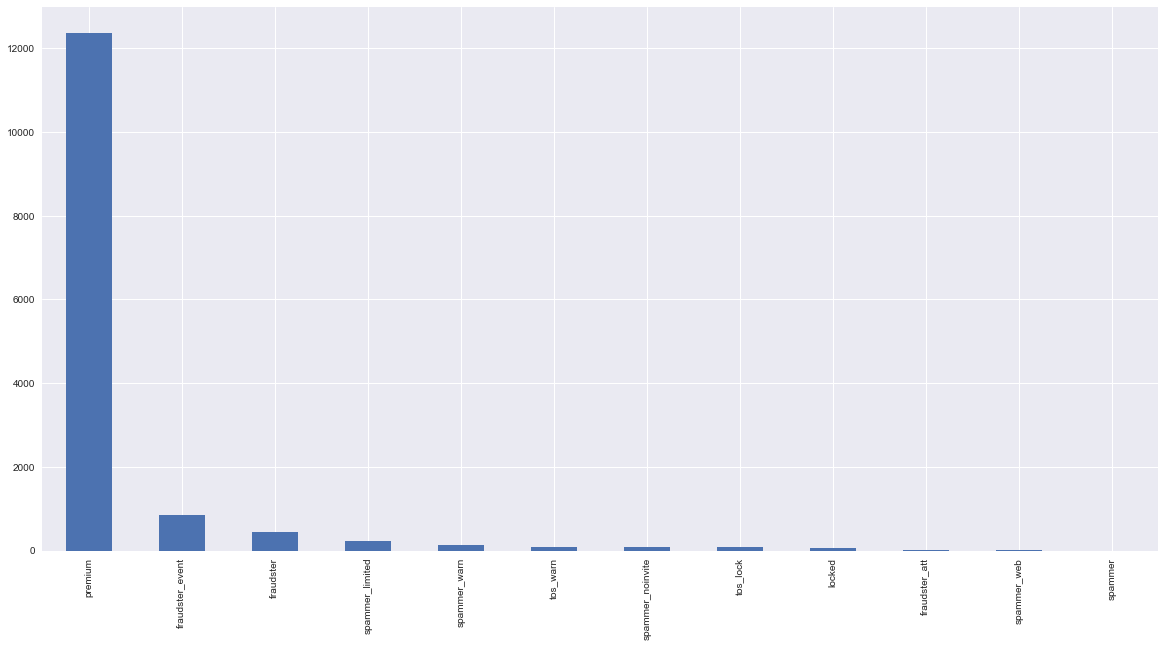

In [6]:
df['acct_type'].value_counts().plot(kind='bar')

In [7]:
set(df.acct_type.values)

{'fraudster',
 'fraudster_att',
 'fraudster_event',
 'locked',
 'premium',
 'spammer',
 'spammer_limited',
 'spammer_noinvite',
 'spammer_warn',
 'spammer_web',
 'tos_lock',
 'tos_warn'}

In [8]:
df['fraud'] = df['acct_type'].apply(lambda x:True if 'fraud' in x else False)

In [9]:
df['fraud'].value_counts()

False    13044
True      1293
Name: fraud, dtype: int64

In [10]:
df1 = df.drop(['ticket_types','previous_payouts'],1)

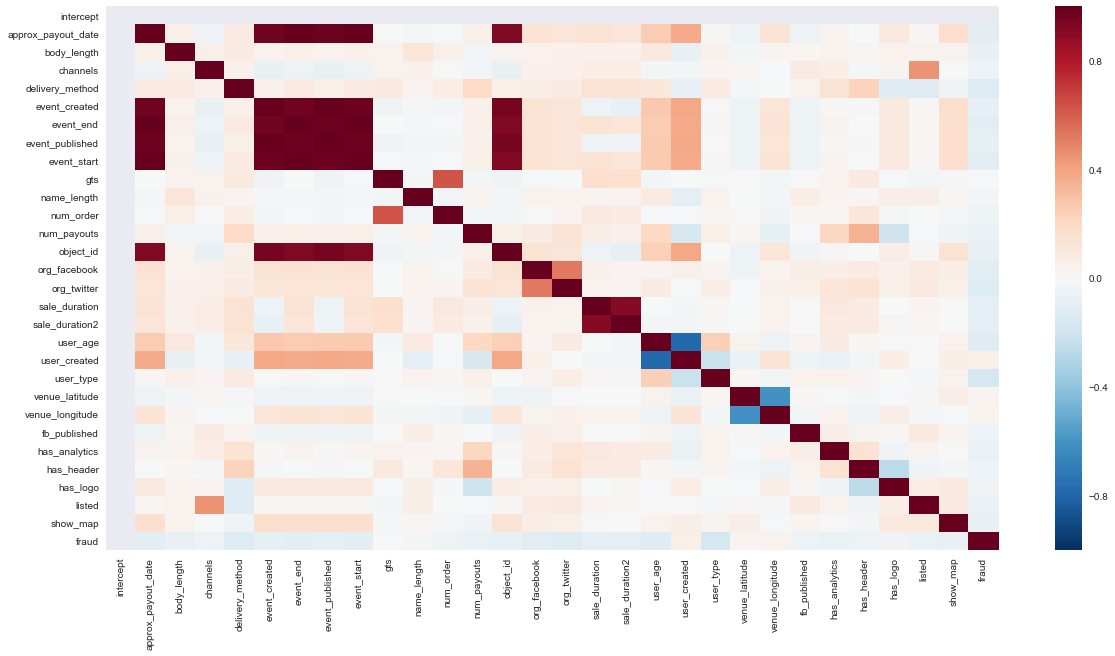

In [11]:
corr = clean_df.corr()
feat = list(clean_df.columns)
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=feat,
        yticklabels=feat)

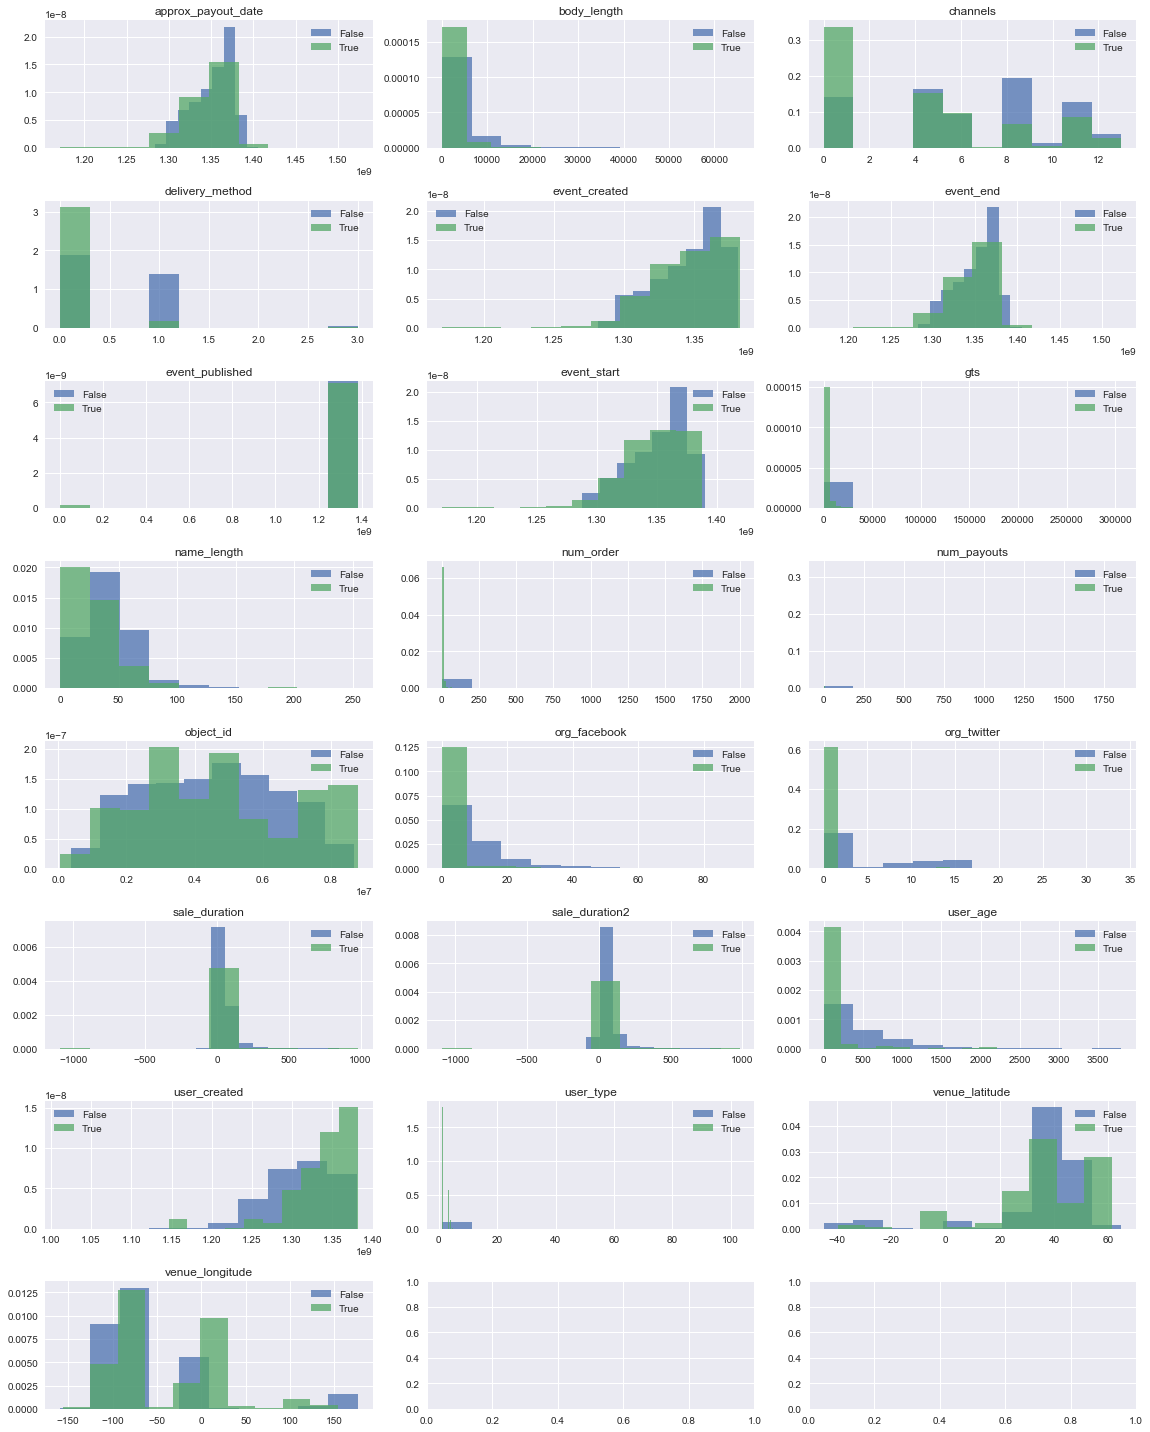

In [12]:
def hist_grouped(df,group_col,hist_col):
    len_col = len(hist_col)
    fig, axis = plt.subplots(math.ceil(len_col/3.),3, figsize=(16, 20))
    for i, pos in zip(range(len_col),axis.flatten()):
        groups = df.groupby(group_col)[hist_col[i]]
        for k, v in groups:
            v.hist(label=str(k), alpha=.75, ax=pos,normed=True)
        pos.legend()
        pos
#         print(hist_col[i])
        pos.set_title(hist_col[i])        
    plt.tight_layout()
    plt.show()


hist_grouped(df1,'fraud',numeric_features)

In [13]:
logit = sm.Logit(clean_df['fraud'], clean_df.drop('fraud',1))
# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.095303
         Iterations 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  fraud   No. Observations:                 8290
Model:                          Logit   Df Residuals:                     8262
Method:                           MLE   Df Model:                           27
Date:                Mon, 17 Apr 2017   Pseudo R-squ.:                  0.4644
Time:                        12:26:47   Log-Likelihood:                -790.07
converged:                       True   LL-Null:                       -1475.1
                                        LLR p-value:                5.233e-272
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
intercept             87.0431     42.691      2.039      0.041         3.371   170.716
approx_payout_date    -0.0002   9.46e-05     -1.828      0.068        -0.000  1.25e-05
body_length        -5.869e-05   2.24e-05     -2.616      0.009        -0.000 -1.47e-05
channels              -0.0534      0.019     -2.758      0.006        -0.091    -0.015
delivery_method       -0.3819      0.173     -2.208      0.027        -0.721    -0.043
event_created      -6.521e-06   6.03e-06     -1.082      0.279     -1.83e-05  5.29e-06
event_end              0.0002   9.46e-05      1.828      0.068     -1.25e-05     0.000
event_published     5.216e-06   5.68e-06      0.918      0.358     -5.92e-06  1.63e-05
event_start        -4.862e-06   2.98e-06     -1.631      0.103     -1.07e-05  9.79e-07
gts                 5.277e-05   7.79e-06      6.778      0.000      3.75e-05   6.8e-05
name_length            0.0034      0.002      1.389      0.165        -0.001     0.008
num_order             -0.0987      0.011     -8.908      0.000        -0.120    -0.077
num_payouts           -0.2770      0.043     -6.463      0.000        -0.361    -0.193
object_id          -1.558e-07   1.29e-07     -1.208      0.227     -4.09e-07  9.71e-08
org_facebook          -0.0213      0.012     -1.761      0.078        -0.045     0.002
org_twitter           -0.1121      0.027     -4.188      0.000        -0.165    -0.060
sale_duration          0.4798      0.490      0.979      0.328        -0.481     1.440
sale_duration2        -0.0696      0.511     -0.136      0.892        -1.071     0.931
user_age               0.5302      0.317      1.674      0.094        -0.091     1.151
user_created        6.129e-06   3.67e-06      1.671      0.095     -1.06e-06  1.33e-05
user_type             -0.9034      0.070    -12.877      0.000        -1.041    -0.766
venue_latitude         0.0202      0.004      4.726      0.000         0.012     0.029
venue_longitude        0.0066      0.001      5.124      0.000         0.004     0.009
fb_published          -0.6035      0.272     -2.217      0.027        -1.137    -0.070
has_analytics         -1.3793      0.535     -2.578      0.010        -2.428    -0.331
has_header             0.0398      0.234      0.170      0.865        -0.419     0.498
has_logo              -0.8230      0.214     -3.839      0.000        -1.243    -0.403
listed                -0.5742      0.188     -3.062      0.002        -0.942    -0.207
show_map              -0.4450      0.169     -2.636      0.008        -0.776    -0.114
======================================================================================

Possibly complete quasi-separation: A fraction 0.39 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [24]:
def model_test(df,name='LinearSVC',clf = LinearSVC()):
    # the pipeline to clean, tokenize, vectorize, and classify
    pipe = Pipeline([('standardscaler',StandardScaler()),('clf', clf)])
    train, test, labelsTrain, labelsTest = train_test_split(df.drop('fraud',1), df['fraud'], test_size=0.15, random_state=66)
#     prepare_data(label_pair,group)
    pipe.fit(train, labelsTrain)
    # test
    preds = pipe.predict(test)
#     print(preds)
    print("----------------------------------------------------------------------------------------------")
    print("results:{}".format(name))
    print('accuracy:{}, recall_score:{}, precision_score:{}'.format(accuracy_score(labelsTest, preds),
                        precision_score(labelsTest, preds,average='macro'),recall_score(labelsTest, preds,average='macro') ))

In [25]:
model_test(clean_df)

----------------------------------------------------------------------------------------------
results:LinearSVC
accuracy:0.9581993569131833, recall_score:0.7031938821412506, precision_score:0.5371201288562365


In [20]:
names = ["Logistic Regression","Nearest Neighbors", "Linear SVM",  "Gaussian Process",
         "Decision Tree", "Random Forest", "AdaBoost",'Gradient Boost', "Neural Net",
         "Naive Bayes", "QDA"] #"RBF SVM",

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    LinearSVC(),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(alpha=1),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name,model in zip(names,classifiers):
    try:
        model_test(clean_df,name,model)
    except:
        print("----------------------------------------------------------------------------------------------")
        print('DOES NOT WORK:{}'.format(name))

----------------------------------------------------------------------------------------------
results:Logistic Regression
accuracy:0.9590032154340836, recall_score:0.4795016077170418, precision_score:0.5
----------------------------------------------------------------------------------------------
results:Nearest Neighbors
accuracy:0.9638263665594855, recall_score:0.7774504669634286, precision_score:0.7089804907713295


/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------------------------------------------
results:Linear SVM
accuracy:0.9590032154340836, recall_score:0.4795016077170418, precision_score:0.5


/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------------------------------------------
results:Gaussian Process
accuracy:0.9590032154340836, recall_score:0.4795016077170418, precision_score:0.5
----------------------------------------------------------------------------------------------
results:Decision Tree
accuracy:0.9766881028938906, recall_score:0.9119740099009901, precision_score:0.7626103249346678
----------------------------------------------------------------------------------------------
results:Random Forest
accuracy:0.9590032154340836, recall_score:0.4795016077170418, precision_score:0.5


/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------------------------------------------
results:AdaBoost
accuracy:0.9831189710610932, recall_score:0.9012332775919732, precision_score:0.8785809378235787
----------------------------------------------------------------------------------------------
results:Gradient Boost
accuracy:0.9831189710610932, recall_score:0.9403203281836432, precision_score:0.8316568873987147
----------------------------------------------------------------------------------------------
results:Neural Net
accuracy:0.9590032154340836, recall_score:0.4795016077170418, precision_score:0.5
----------------------------------------------------------------------------------------------
results:Naive Bayes
accuracy:0.7813504823151125, recall_score:0.5327647212751675, precision_score:0.6419966142366419
----------------------------------------------------------------------------------------------
results:QDA
accuracy:0.7998392282958199, recall_score:0.5644538268056055,

/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [26]:
names = ["Logistic Regression","Nearest Neighbors", "Linear SVM",  "Gaussian Process",
         "Decision Tree", "Random Forest", "AdaBoost",'Gradient Boost', "Neural Net",
         "Naive Bayes", "QDA"] #"RBF SVM",

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    LinearSVC(),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(alpha=1),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name,model in zip(names,classifiers):
    try:
        model_test(clean_df,name,model)
    except:
        print("----------------------------------------------------------------------------------------------")
        print('DOES NOT WORK:{}'.format(name))

----------------------------------------------------------------------------------------------
results:Logistic Regression
accuracy:0.9606109324758842, recall_score:0.7682346109175378, precision_score:0.5759167036470917
----------------------------------------------------------------------------------------------
results:Nearest Neighbors
accuracy:0.9694533762057878, recall_score:0.8192932303387872, precision_score:0.758838321581776
----------------------------------------------------------------------------------------------
results:Linear SVM
accuracy:0.9581993569131833, recall_score:0.7031938821412506, precision_score:0.5371201288562365
----------------------------------------------------------------------------------------------
DOES NOT WORK:Gaussian Process
----------------------------------------------------------------------------------------------
results:Decision Tree
accuracy:0.9758842443729904, recall_score:0.899181743112379, precision_score:0.7621912134510133
-------------

/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------------------------------------------
results:AdaBoost
accuracy:0.9831189710610932, recall_score:0.9012332775919732, precision_score:0.8785809378235787
----------------------------------------------------------------------------------------------
results:Gradient Boost
accuracy:0.9831189710610932, recall_score:0.9403203281836432, precision_score:0.8316568873987147
----------------------------------------------------------------------------------------------
results:Neural Net
accuracy:0.9742765273311897, recall_score:0.9442367268454225, precision_score:0.7050441299738672
----------------------------------------------------------------------------------------------
results:Naive Bayes
accuracy:0.7347266881028939, recall_score:0.5527434076603409, precision_score:0.7772299196292096
----------------------------------------------------------------------------------------------
results:QDA
accuracy:0.7990353697749196, recall_score:0.56

/Applications/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [4]:
df1 = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2015_06_30_precipitation.csv')
df1.head()


,Hrapx,Hrapy,Lat,Lon,Globvalue
0,272.3333,670.2500,48.4113,-112.8352,0.0875
1,1546.5000,195.1667,18.0057,-65.8040,0.0892
2,262.2500,674.2500,48.6163,-113.4784,0.0908
3,252.5000,674.6667,48.5379,-114.0702,0.0933
4,302.1667,671.4167,48.5843,-111.0188,0.0942
